#**Exploratory Data Analysis of GTZAN**


In [ ]:
!pip install python_speech_features


In [ ]:
!pip install pydub


In [377]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from pydub import AudioSegment
from python_speech_features import mfcc
from sklearn.metrics import classification_report
from collections import defaultdict

In [ ]:
df = pd.read_csv("features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
df.shape

(9990, 60)

In [ ]:
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [ ]:
df=df.drop(labels="filename",axis=1)

In [ ]:
df['label']

0       blues
1       blues
2       blues
3       blues
4       blues
        ...  
9985     rock
9986     rock
9987     rock
9988     rock
9989     rock
Name: label, Length: 9990, dtype: object


# **Understanding the audio files better**

In [ ]:
audio_recording="/content/metal.00005.wav"
data,sr=librosa.load(audio_recording)
print(type(data),type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
librosa.load(audio_recording,sr=45600)

(array([-0.23458964, -0.2917654 , -0.2915146 , ..., -0.04705553,
        -0.03816718,  0.        ], dtype=float32), 45600)

In [ ]:
import IPython
IPython.display.Audio(data,rate=sr)

# **Visualisation of the Audio Files**

> **Raw Files**
>>Waveforms are visual representations of sound as time on the x-axis and amplitude on the y-axis. They are great for allowing us to quickly scan the audio data and visually compare and contrast which genres might be more similar than others.

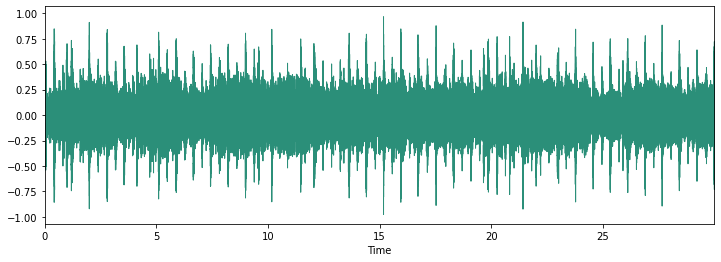

In [ ]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(data,color="#2B8F79")
plt.show()

> **Spectrogram**
>>A spectrogram is a visual way of representing the signal loudness of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time. Spectrograms are sometimes called sonographs, voiceprints, or voicegrams. When the data is represented in a 3D plot, they may be called waterfalls. In 2-dimensional arrays, the first axis is frequency while the second axis is time

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


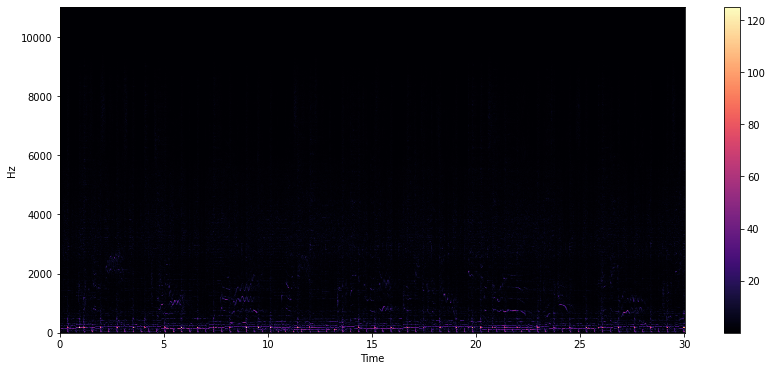

In [371]:
stft=librosa.stft(data)
stft_db=librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

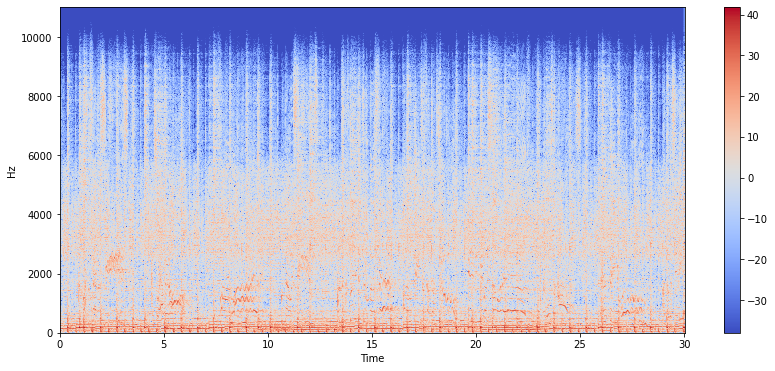

In [ ]:
stft=librosa.stft(data)
stft_db=librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

>**Chroma Feature**
>>It is a powerful tool for analyzing music features whose pitches can be meaningfully categorized and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music while being robust to changes in timbre and instrumentation

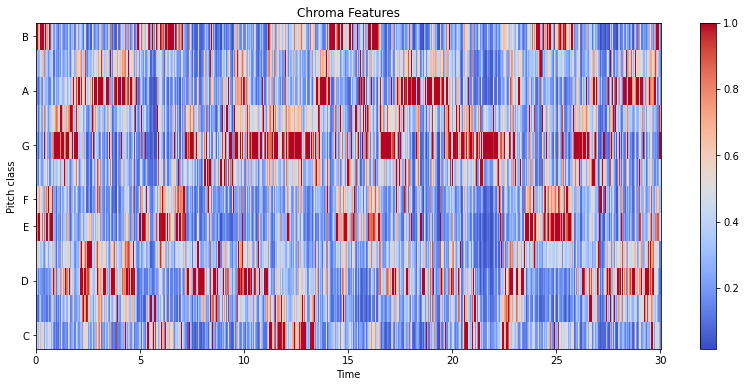

In [372]:
import librosa.display as lplt
chroma = librosa.feature.chroma_stft(data,sr=sr)
plt.figure(figsize=(14,6))
lplt.specshow(chroma,sr=sr,x_axis="time",y_axis="chroma",cmap="coolwarm")
plt.colorbar()
plt.title("Chroma Features")
plt.show()

>**Zero Crossing Rate**
>>Zero crossing is said to occur if successive samples have different algebraic signs. The rate at which zero-crossings occur is a simple measure of the frequency content of a signal. Zero-crossing rate is a measure of the number of times in a given time interval/frame that the amplitude of the speech signals passes through a value of zero.

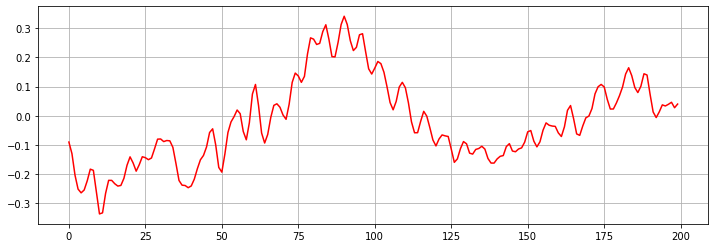

In [373]:
start=1000
end=1200
plt.figure(figsize=(12,4))
plt.plot(data[start:end],color="red")
plt.grid()

In [374]:
zero_cross_rate=librosa.zero_crossings(data[start:end],pad=False)
print("the numbert of zero_crossings is :", sum(zero_cross_rate))

the numbert of zero_crossings is : 15


# **Feature Extraction**
> Preprocessing of data is required before we finally train the data. We will try and focus on the last column that is ‘label’ and will encode it with the function LabelEncoder() of sklearn.preprocessing.

In [ ]:
class_list=df.iloc[:,-1]
converter=LabelEncoder()

In [ ]:
y=converter.fit_transform(class_list)
y

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
print(df.iloc[:,:-1])

      length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var
0      66149          0.335406  ...    -0.243027   43.771767
1      66149          0.343065  ...     5.784063   59.943081
2      66149          0.346815  ...     2.517375   33.105122
3      66149          0.363639  ...     3.630866   32.023678
4      66149          0.335579  ...     0.536961   29.146694
...      ...               ...  ...          ...         ...
9985   66149          0.349126  ...     1.818823   38.966969
9986   66149          0.372564  ...     0.428857   18.697033
9987   66149          0.347481  ...    -0.299545   41.586990
9988   66149          0.387527  ...     0.675824   12.787750
9989   66149          0.369293  ...    -3.412534   31.727489

[9990 rows x 58 columns]


# **Scaling the features**
Standard scaler is used to standardize features by removing the mean and scaling to unit variance. 

In [ ]:
from sklearn.preprocessing import StandardScaler
fit=StandardScaler()
X=fit.fit_transform(np.array(df.iloc[:,:-1],dtype=float))

# **Dividing Training and Testing Dataset**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)

In [ ]:
len(y_test)

3297

In [ ]:
len(y_train)

6693

# **Building the CNN model**

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
def trainModel(model,epochs,optimizer):
    batch_size=128
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics='accuracy')
    return model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

In [ ]:
def plotValidate(history):
    print("Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [ ]:
import tensorflow as tf

In [ ]:
 # build network topology
     # 1st conv layer
     
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(512,activation='relu',input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
     # 2nd conv layer
    tf.keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    
    # 3rd conv layer
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    #Feed it into dense layer
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
   
    # output layer
    tf.keras.layers.Dense(10,activation='softmax'),
])

print(model.summary())
model_history=trainModel(model=model,epochs=500,optimizer='adam')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 512)               30208     
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 128)              

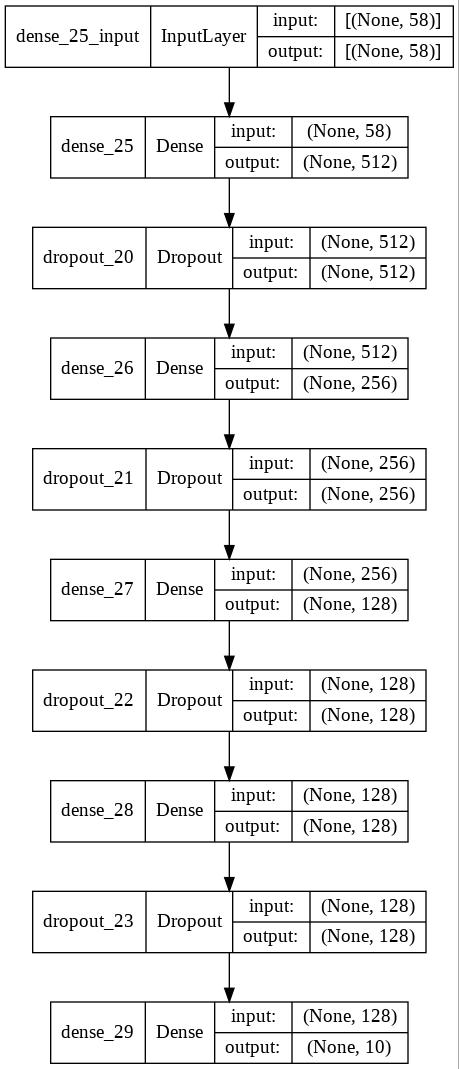

In [ ]:
plot_model(model,'model.jpg', show_shapes=True)


In [ ]:
test_loss,test_acc=model.evaluate(X_test,y_test,batch_size=128)
print("The test loss is ",test_loss)
print("The best accuracy is: ",test_acc*100)

26/26 [==============================] - 0s 4ms/step - loss: 0.4537 - accuracy: 0.9242
The test loss is  0.45368140935897827
The best accuracy is:  92.41734743118286


In [375]:
y_predicted = model.predict(X_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[309,   0,   6,   3,   0,   2,   3,   0,   3,   4],
       [  0, 314,   4,   0,   0,  11,   0,   1,   0,   1],
       [  9,   2, 291,   6,   1,  10,   2,   7,   4,   9],
       [  1,   2,   1, 307,   2,   1,   4,   5,   2,   7],
       [  0,   0,   4,   5, 327,   0,   3,   7,   1,   2],
       [  3,   3,   5,   0,   0, 286,   0,   0,   0,   1],
       [  2,   1,   0,   0,   1,   0, 328,   0,   0,   5],
       [  0,   2,   4,   8,   5,   2,   0, 301,   5,   4],
       [  1,   0,   1,   4,   7,   4,   4,   3, 287,   3],
       [  0,   2,  12,   7,   2,   0,   7,   5,   2, 297]], dtype=int32)>

Text(123.0, 0.5, 'Truth')

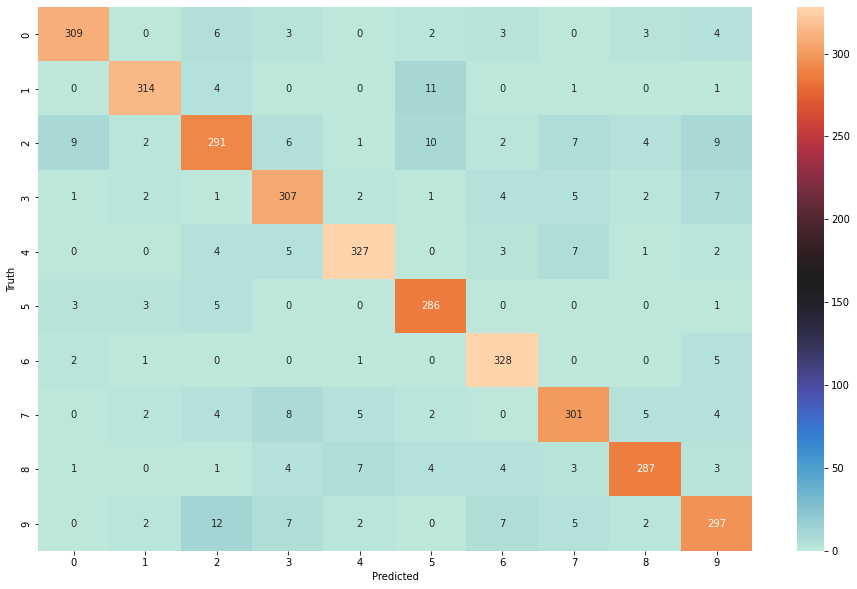

In [378]:

plt.figure(figsize = (16,10))
sns.heatmap(cm, annot=True, fmt='d', cmap = 'icefire')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#**Saving Model**

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
model.save('/content/model/model.h5')

In [ ]:
from tensorflow import keras
model= keras.models.load_model('/content/model/model.h5')

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 512)               30208     
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 128)              

# **Plotting the Accuracy and the Error**

<Figure size 2160x2160 with 0 Axes>

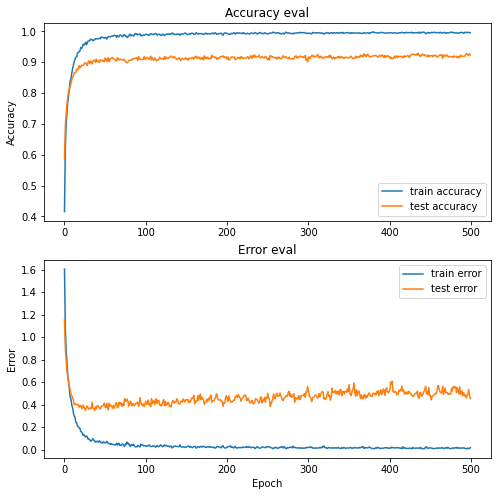

In [ ]:
plt.figure(figsize=(30,30))
fig, axs = plt.subplots(2,figsize=(8,8))

# accuracy 
axs[0].plot(model_history.history["accuracy"], label="train accuracy")
axs[0].plot(model_history.history["val_accuracy"], label="test accuracy")    
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")
                 
axs[1].plot(model_history.history["loss"], label="train error")
axs[1].plot(model_history.history["val_loss"], label="test error")    
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")
    
plt.show()                 

#**Testing the Audio files**

In [ ]:
def features(audio,sr, hl=5000):
   mean_var = lambda x: [np.mean(x, 0), np.var(x, 0)]

   length = np.shape(audio)[0]

   _chroma_stft = librosa.feature.chroma_stft(audio,sr=sr, hop_length=hl)
   chroma_stft = np.squeeze(_chroma_stft.reshape((1,-1)))

   rms = np.squeeze(librosa.feature.rms(audio))

   spec_centr = librosa.feature.spectral_centroid(audio, sr=sr)[0]
   spec_bw = librosa.feature.spectral_bandwidth(audio, sr=sr)[0]
   spec_rolloff = librosa.feature.spectral_rolloff(audio, sr=sr)[0]

   zcr = librosa.zero_crossings(audio, pad=False)

   harm, perc = librosa.effects.hpss(audio)
   tempo, _ = librosa.beat.beat_track(audio, sr=sr)

   feature_list = [length]
   for x in [chroma_stft, rms, spec_centr, spec_bw, spec_rolloff, zcr, harm, perc]:
      feature_list = feature_list + mean_var(x)

   feature_list.append(tempo)

   for x in librosa.feature.mfcc(audio, sr=sr):
      feature_list = feature_list + mean_var(x)

   return fit.transform(np.array(feature_list,dtype=float).reshape(1,-1))

In [368]:
def slice_into(slices, data, sr):
  slice_len = int(data.shape[0]/slices)
  return np.split(data, np.arange(1,slices) * slice_len)
def best_fit_genres(class_list, preds, num_top=1):
  idx_preds = np.argsort(preds)
  return np.array(class_list)[idx_preds[::-1][:num_top]]

In [381]:
audio_file="/content/John Denver - Take Me Home, Country Roads (Audio).mp3"

In [382]:
audio,sr = librosa.load(audio_file)
acc_pred = np.zeros(len(converter.classes_))
#IPython.display.Audio(slice_into(10, audio, sr)[1],rate=sr)
for a in slice_into(10, audio, sr) :
  a_features = features(a, sr)
  #print(a_features.shape)
  pred_audio = model.predict(a_features)
  pred_audio[0,np.argmax(pred_audio)] = 1
  final = np.asarray(np.squeeze(pred_audio),dtype=np.int32)
  #print(final)
  acc_pred = acc_pred + final

print(acc_pred)
# len(acc_pred)
print(best_fit_genres(converter.classes_, acc_pred))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[ 0.  0. 10.  0.  0.  0.  0.  0.  0.  0.]
['country']
